# HEART RHYTHM CLASSIFICATION FROM RAW ECG SIGNALS
While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

In [4]:
# We start importing some modules and running some magic commands
%matplotlib inline
%reload_ext autoreload
%reload_ext autoreload
%autoreload 2

# General math and plotting modules.
! pip install biosppy
#! pip install PyWavelets
import numpy as np
import pywt
import pandas as pd
import biosppy # lib to handle ecg signals electrocardiac graphic signals
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error  #the library to calculate the mean squared error (mean squared residual)
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression #this is the Linear regression model library
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV#library for the regression
from scipy import stats #to use mode

In [5]:
#Create the nan Statistics pd for the training features
def print_nan_statistics(xtraining_data):
    num_X_samples = len(xtraining_data)
    nan_stats_x = pd.DataFrame({'Nan number': xtraining_data.isnull().sum() , 'Nan %':xtraining_data.isnull().sum()*100/num_X_samples})
    get_index = nan_stats_x.index
    return nan_stats_x

# Preprocessing of input data

In [6]:
#import the csv data
x_train = pd.read_csv("X_train.csv", low_memory =False) #load the data from the train.csv file
x_test = pd.read_csv("X_test.csv", low_memory = False) #load the data from the train.csv file
y_train = pd.read_csv("Y_train.csv" , low_memory = False)
sample = pd.read_csv("sample.csv") #load data from the samples.csv-no needed in this case, because it is given for demonstration purposes
train_5rows = x_train.head() #print the first 5 rows of data 
#print(train_5rows)


#Extract the x values for training
print("X values from the training dataset")
print(x_train)
print("Y values from the training dataset")
print(y_train) #print the (programming) type of the matrix (it's of panda type)
print(x_test)

X values from the training dataset
        id    x0    x1    x2    x3    x4    x5    x6    x7    x8  ...  x17969  \
0        0  -863  -860  -857  -854  -851  -849  -846  -843  -838  ...     NaN   
1        1  -137  -132  -123  -107   -79   -59   -45   -47   -70  ...     NaN   
2        2  -727  -736  -748  -784  -831  -874  -917  -967 -1029  ...     NaN   
3        3  -103   -98   -92   -87   -81   -77   -71   -65   -61  ...     NaN   
4        4     8     2    -1    -3    -5    -7   -10   -12   -14  ...     NaN   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
5112  5112   -88  -158  -237  -316  -384  -437  -487  -505  -504  ...     NaN   
5113  5113     7     4     1     0    -3    -7   -12   -22   -36  ...     NaN   
5114  5114 -1464 -1454 -1445 -1437 -1431 -1422 -1390 -1327 -1256  ...     NaN   
5115  5115  -259  -258  -256  -253  -250  -245  -239  -226  -201  ...     NaN   
5116  5116    24    30    35    39    41    40    38    35    31  ...     

In [7]:
#Seperate training data to their classes based on y value in label data
class0_labels = y_train.loc[y_train['y']==0]
class1_labels = y_train.loc[y_train['y']==1]
class2_labels = y_train.loc[y_train['y']==2]
class3_labels = y_train.loc[y_train['y']==3]
print("The class0 shape is",class0_labels.shape)
print("The class1 shape is",class1_labels.shape)
print("The class2 shape is",class2_labels.shape)
print("The class3 shape is",class3_labels.shape)


#Extract the id list for each class
id_array_of_class0 = class0_labels['id'].reset_index(drop=True)
id_array_of_class1 = class1_labels['id'].reset_index(drop=True)
id_array_of_class2 = class2_labels['id'].reset_index(drop=True)
id_array_of_class3 = class3_labels['id'].reset_index(drop=True)
print("An example of id array for class0");print(id_array_of_class0);print()



#Seperate training data to each class based on each id mask
class0_train = x_train.loc[x_train['id'].isin(id_array_of_class0.values)].reset_index(drop=True)
class1_train = x_train.loc[x_train['id'].isin(id_array_of_class1.values)].reset_index(drop=True)
class2_train = x_train.loc[x_train['id'].isin(id_array_of_class2.values)].reset_index(drop=True)
class3_train = x_train.loc[x_train['id'].isin(id_array_of_class3.values)].reset_index(drop=True)
print("An example of training data for class 0");print(class0_train)

#Get all training and testing data together
x_train_no_id = x_train.loc[: , x_train.columns!= 'id']
y_train_no_id = y_train['y']
x_test_no_id = x_test.loc[: , x_test.columns!= 'id']

The class0 shape is (3030, 2)
The class1 shape is (443, 2)
The class2 shape is (1474, 2)
The class3 shape is (170, 2)
An example of id array for class0
0          0
1          1
2          2
3          4
4          6
        ... 
3025    5108
3026    5110
3027    5114
3028    5115
3029    5116
Name: id, Length: 3030, dtype: int64

An example of training data for class 0
        id    x0    x1    x2    x3    x4    x5    x6    x7    x8  ...  x17969  \
0        0  -863  -860  -857  -854  -851  -849  -846  -843  -838  ...     NaN   
1        1  -137  -132  -123  -107   -79   -59   -45   -47   -70  ...     NaN   
2        2  -727  -736  -748  -784  -831  -874  -917  -967 -1029  ...     NaN   
3        4     8     2    -1    -3    -5    -7   -10   -12   -14  ...     NaN   
4        6     8     7     6     6     5     5     5     5     4  ...     NaN   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
3025  5108  -406  -422  -432  -416  -367  -297  -214  -126  

### ECG Visualization

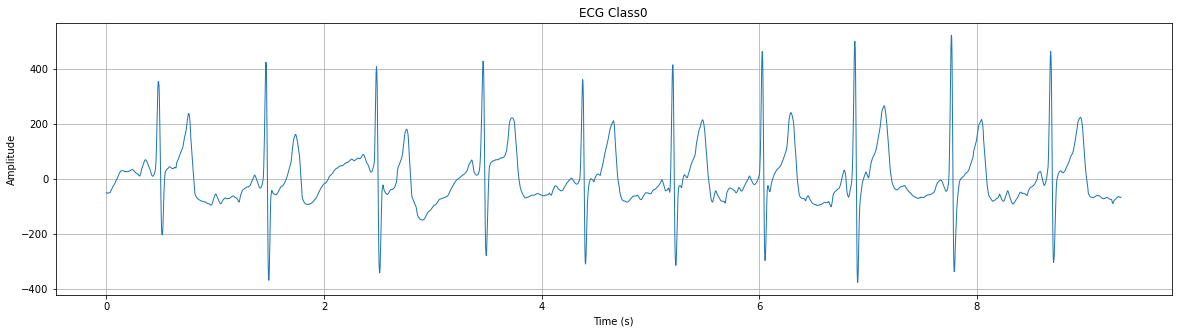

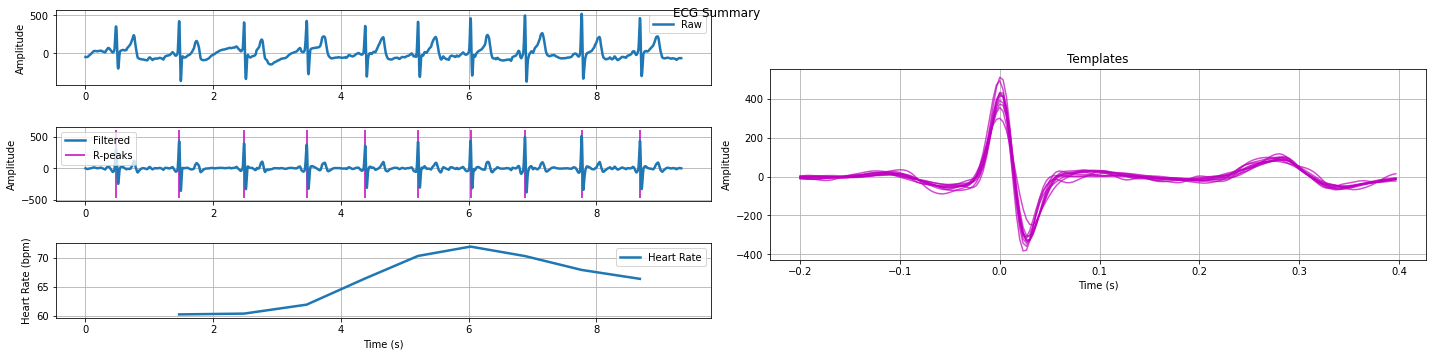

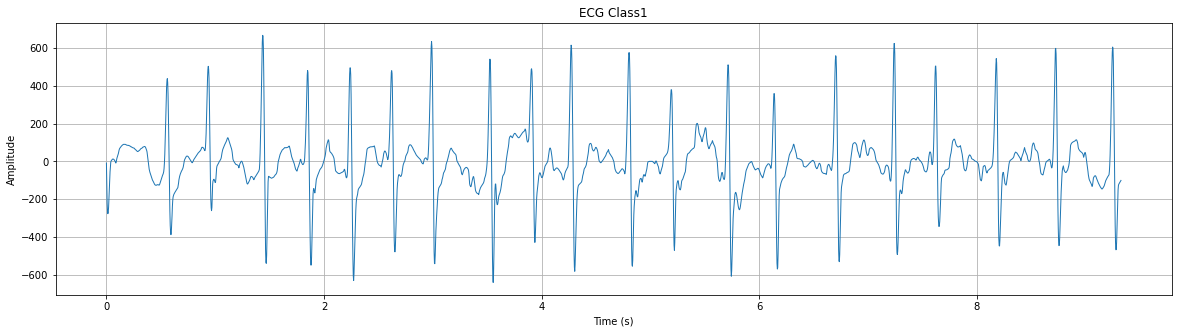

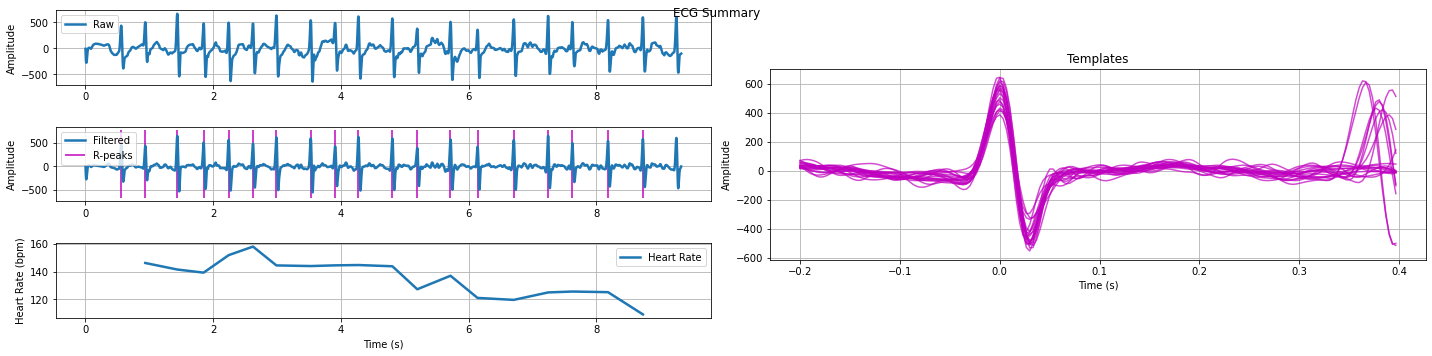

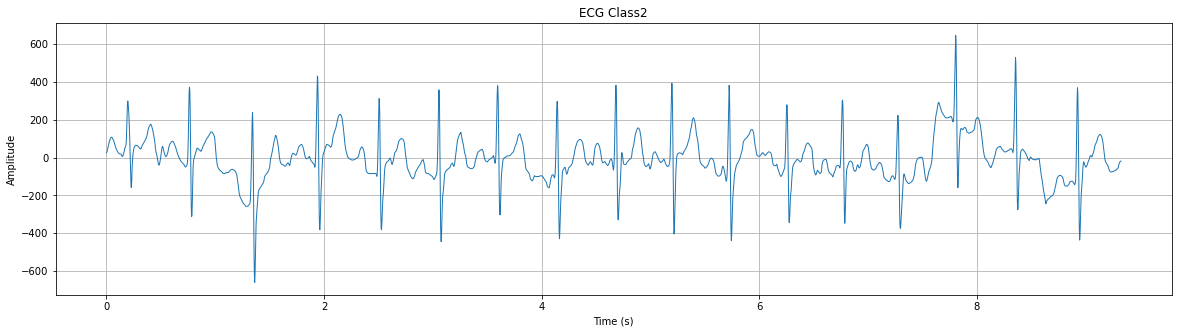

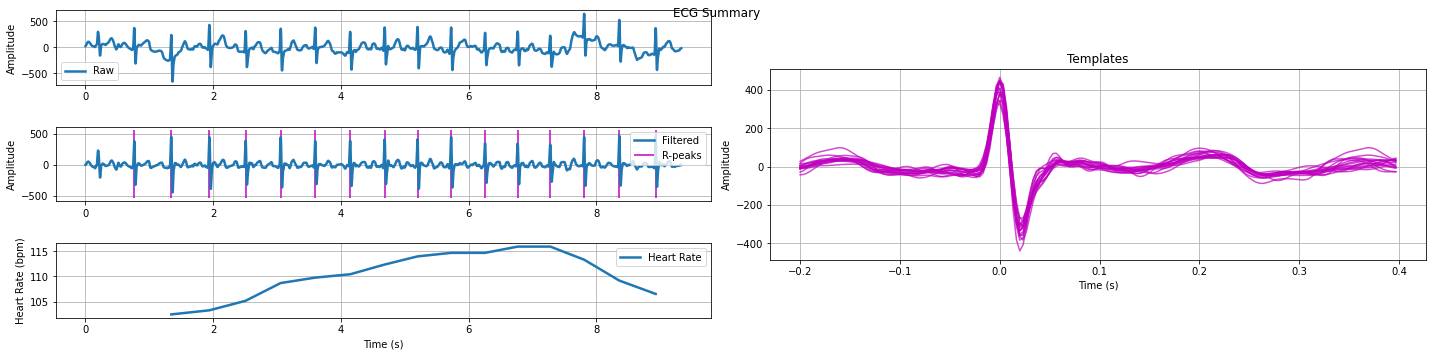

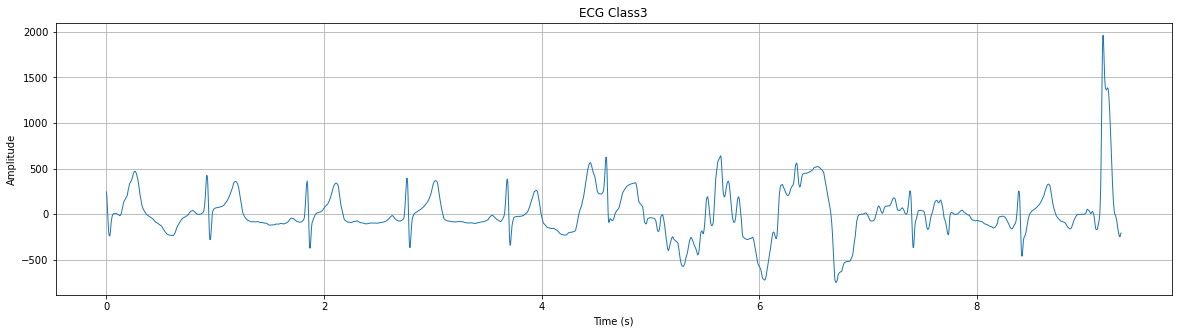

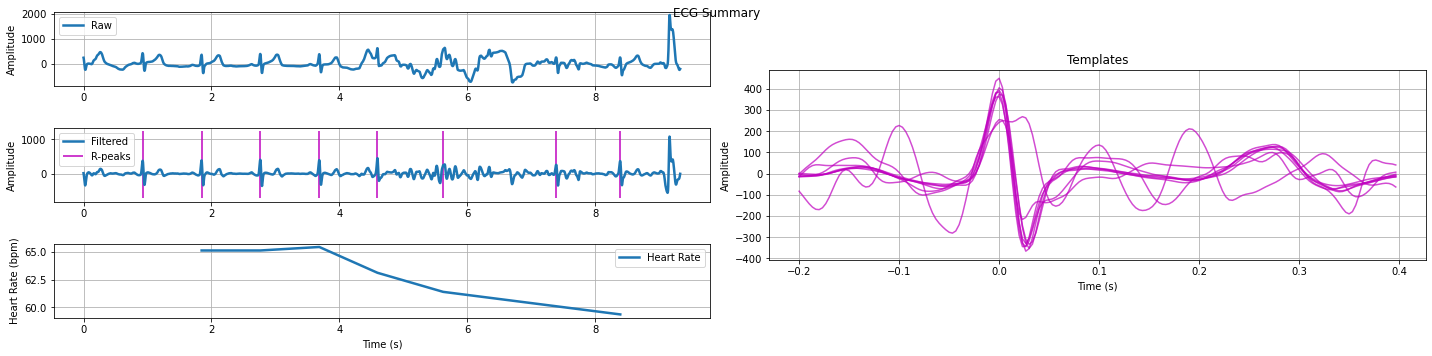

In [8]:
#from biosppy import storage 
from biosppy.signals import ecg
sample_signal0 = class0_train.iloc[1,200:3000]
sample_signal1 = class1_train.iloc[1,200:3000]
sample_signal2 = class2_train.iloc[1,200:3000]
sample_signal3 = class3_train.iloc[1,200:3000]
sample_signals = [sample_signal0, sample_signal1, sample_signal2, sample_signal3]
counter = 0 
for ecg_signal in sample_signals:
    Fs = 300 #300Hz
    N = len(ecg_signal)  # number of samples
    T = (N - 1) / Fs  # duration
    ts = np.linspace(0, T, N, endpoint=False)  # relative timestamps
    title = 'ECG Class'+str(counter)
    plt.rcParams["figure.figsize"] = (20,5)
    #fig = plt.figure(figsize=(4.8,4.8))
    plt.plot(ts, ecg_signal, lw=1)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.grid()
    plt.title(title)
    plt.show()
    counter = counter+1
    out = ecg.ecg(signal= ecg_signal, sampling_rate=300.0, show=True)

In [9]:
def autocorrelation_array(array):
    list_auto = []
    for i in range(0,len(array)):
        series = pd.Series(x_raw_train[i])
        autocorrelation = series.autocorr(lag=2)
        list_auto.append(autocorrelation)
    return np.array(list_auto)


def highest_coefficients(fft_array, top_n):
    highC_index= fft_array.argsort()[: , -top_n:]#sorting from lower to greater and taking the last elements
    highC = fft_array[np.arange(fft_array.shape[0])[:,None],highC_index]
    return highC


    
    
    
def lowest_coefficients(fft_array , top_n):
    lowC_index = fft_array.argsort()[: , :top_n]#sorting from lower to greater and taking the first lowest n coefficients
    lowC = fft_array[np.arange(fft_array.shape[0])[:,None],lowC_index]
    return lowC
    
    
        
        

In [10]:
'''Find the maximum last valid_index and pad all sequences until this column/time stamp'''
def pad(dataset):
    padded_sequences = []
    max = 0 
    for i in range(0,dataset.shape[0]):
        sequence = np.transpose(np.array(dataset.iloc[0,:]))
        series =pd.Series(sequence) #needs a vector array (row vector)
        last =series.last_valid_index()
        if (last > max):
            max = last
        series.iloc[last:] = 0
        padded_sequences.append(series)
    print("The maximum valid index is ", max)
    return np.array(padded_sequences)[: , :10000]


### Mean, Median, Power, Autocorellation and FFT 

In [11]:
#Get rid of all columns with nanValues
#x_raw_train = pad(x_train_no_id)#x_train_no_id.dropna(1) #corresponding to columns
x_raw_train = pd.read_csv("X_train_prepared.csv",low_memory = False).to_numpy()[: ,:] #remove the initial noisy signals
x_raw_test = pd.read_csv("X_test_prepared.csv",low_memory = False).to_numpy()[: , :] #remove the initial noisy signals
#x_raw_test = pad(x_test_no_id) #x_train_no_id.to_numpy()



print("The train padded data have shape",x_raw_train.shape)
print("The test padded data have shape",x_raw_test.shape)

#Calculate average amplitude
mean_train = np.mean(x_raw_train , axis = 1)
mean_test = np.mean(x_raw_test , axis = 1)
print('Mean signal has shape ', mean_train.shape)


#Calculate average median
median_train = np.median(x_raw_train , axis = 1 )
median_test = np.median(x_raw_test , axis = 1 )
print('Median of signals has shape ', median_train.shape)

#Calculate the power of the signals
ptp_train = np.ptp(x_raw_train,axis=1)
ptp_test = np.ptp(x_raw_test ,axis=1)
print('Power of signals has shape ', ptp_train.shape)

#Calculate the FFT and highest and lowest coefficients of each signal
n_high = 20  #store the n highest and lowest frequencies
n_low = 10
FFT_train = np.fft.fft(x_raw_train,axis=1)
highCoeff = highest_coefficients(FFT_train, n_high)
lowCoeff = lowest_coefficients(FFT_train, n_low)
coeff_train = np.concatenate((highCoeff,lowCoeff),axis=1)

print('The Fast Fourier Transform for all signals has shape ', FFT_train.shape)
print('The shape of the highest coefficients from the FFT is ',highCoeff.shape)
print('The shape of the lowest coefficients from the FFT is ',lowCoeff.shape)
print('The final shape of the FTT coefficients is', coeff_train.shape)

FFT_test = np.fft.fft(x_raw_test,axis=1)
highCoeff = highest_coefficients(FFT_test, n_high)
lowCoeff = lowest_coefficients(FFT_test, n_low)
coeff_test = np.concatenate((highCoeff , lowCoeff),axis=1)

The train padded data have shape (5117, 8500)
The test padded data have shape (3411, 8500)
Mean signal has shape  (5117,)
Median of signals has shape  (5117,)
Power of signals has shape  (5117,)
The Fast Fourier Transform for all signals has shape  (5117, 8500)
The shape of the highest coefficients from the FFT is  (5117, 20)
The shape of the lowest coefficients from the FFT is  (5117, 10)
The final shape of the FTT coefficients is (5117, 30)


In [12]:
#autocorrelation for each time step
autoCorr_train = np.array(autocorrelation_array(x_raw_train))
print('Autocorrelation shape data has shape ' ,autoCorr_train.shape)
autoCorr_test = np.array(autocorrelation_array(x_raw_test))
print('Autocorrelation shape data has shape ' ,autoCorr_test.shape)

Autocorrelation shape data has shape  (5117,)
Autocorrelation shape data has shape  (3411,)


## Signal feature extraction (Spectral and Frequency Domain stats)

In [13]:
#Final Extracted Features for Training and Testing related to the Spectral adn Frequency Domain
train_signal_related_features = np.transpose(np.array([mean_train,median_train,ptp_train,autoCorr_train]))
test_signal_related_features = np.transpose(np.array([mean_test,median_test,ptp_test,autoCorr_test]))
train_frequency_domain_statistics = coeff_train
test_frequency_domain_statistics = coeff_test

In [14]:
#Negative indexing example
a = [10,20,30,40,50,60,70,80,90,100,110,120]
ar = np.array(a)

ind = np.argsort(ar)[-4:-8] #wrong, we keep moving from smaller to greater number
ind = np.argsort(ar)[:-4] #all previous negative numbers, με λίγα λόγια, κρατάμε τα πάντα εκτος από τα τελεύταία 4 elements
ind = np.argsort(ar)[-4:] [::-1]#the last 4 elements of the array but with reverse order
#[::1] go from first index element to the next using an index step of 1 forward
#[::-1] go from last index element using an recerse index step of 1

#so we have elements from -infinity to -1 and an alternative way of 0 to +infinity

print(ind)

[11 10  9  8]


### BioSPPY

In [15]:
def extract_ecg_info(dataset , test=0):
    # ts (array) – Signal time axis reference (seconds).
    #filtered (array) – Filtered ECG signal.
    #rpeaks (array) – R-peak location indices.
    #templates_ts (array) – Templates time axis reference (seconds).
    #templates (array) – Extracted heartbeat templates.
    #heart_rate_ts (array) – Heart rate time axis reference (seconds).
    #heart_rate (Instantenuous heart rate)
    
    ts_list = []
    filtered_list =[]
    rpeaks_list = []
    templates_ts_list = []
    templates_list = []
    heartrate_ts_list= []
    heartrate_list = []
    for i in range(0,len(dataset)):
        index = i
        if (index==383 and test==0):
            print('Copy that')
            index=6
        
        ts,filtered,rpeaks,templates_ts,templates,heart_rate_ts, heart_rate = biosppy.ecg.ecg(dataset[index] ,
                                                                            sampling_rate=300.0, show=False)
        ts_list.append(ts)
        filtered_list.append(filtered)
        rpeaks_list.append(rpeaks)
        templates_ts_list.append(templates_ts)
        templates_list.append(templates)
        heartrate_ts_list.append(heart_rate_ts)
        heartrate_list.append(heart_rate)
        
    return np.array(ts_list),np.array(filtered_list),np.array(rpeaks_list),np.array(templates_ts_list),np.array(templates_list),np.array(heartrate_ts_list),np.array(heartrate_list)

In [16]:
ts_train ,filtered_train ,rpeaks_train, templates_ts_train , templates_train ,heart_rate_ts_train ,heart_rate_train = extract_ecg_info(x_raw_train) #it will np.array

Copy that


In [17]:
ts_test ,filtered_test ,rpeaks_test, templates_ts_test , templates_test ,heartrate_ts_test ,heart_rate_test = extract_ecg_info(x_raw_test ,test=1)

### Normalize & Extract ECG Average/Median Heartbeats per Patient

In [18]:
from sklearn.preprocessing import normalize

def extract_normalized_heartbeats(templates):
    patients = len(templates)
    average_patient_heartbeats = []
    median_patient_heartbeats = []
    print("The number of patients in the dataset is" , patients)
    print("For patient 5 the template is of size ",templates_train[5].shape , " corresponding to " , templates_train[5].shape[0] , " different heartbeats that are being represented by ", templates_train[5].shape[1] , " points each ")
    print("Heartbeats extracted succesfully! \n")
    for i in range(0, patients):
        normalized_patient_template  = normalize(templates[i]) #Normalize templates
        average_patient_beat = np.mean(normalized_patient_template ,axis = 0)
        median_patient_beat = np.median(normalized_patient_template , axis = 0)
        average_patient_heartbeats.append(average_patient_beat)
        median_patient_heartbeats.append(median_patient_beat)
    
    average_heartbeats = np.array(average_patient_heartbeats)
    median_heartbeats = np.array(median_patient_heartbeats)
    
    return average_heartbeats , median_heartbeats


#Train and test Heartbeats
average_heartbeats_train , median_heartbeats_train = extract_normalized_heartbeats(templates_train)
average_heartbeats_test , median_heartbeats_test = extract_normalized_heartbeats(templates_test)

The number of patients in the dataset is 5117
For patient 5 the template is of size  (49, 180)  corresponding to  49  different heartbeats that are being represented by  180  points each 
Heartbeats extracted succesfully! 

The number of patients in the dataset is 3411
For patient 5 the template is of size  (49, 180)  corresponding to  49  different heartbeats that are being represented by  180  points each 
Heartbeats extracted succesfully! 



### Average & Median Heartbeat Visualization 

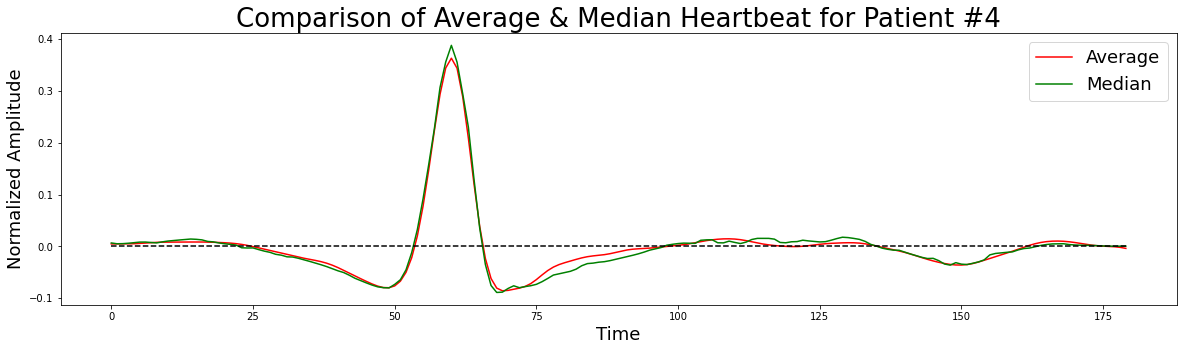

In [19]:
#Visualize a single heartbeat (average and median profile) for ecg signal for patient #5
plt.plot(average_heartbeats_train[4], "-r" )
plt.plot(median_heartbeats_train[4] , "-g" )
plt.plot(np.arange(0,180),np.zeros(180) ,"--k") # plot dashed 0 line with black color
plt.ylabel("Normalized Amplitude",fontsize=18)
plt.xlabel("Time",fontsize= 18)
plt.title("Comparison of Average & Median Heartbeat for Patient #4" ,fontsize=26)
plt.legend(["Average","Median"] ,prop={'size': 18})

plt.show()

## Extract P,Q,R,S,T peaks

###  Method 1: Get average/median heartbeat per patient and extract all peaks from there

In [20]:

def extract_PQRST_features(average_heartbeats ,median_heartbeats ):

    patients  = average_heartbeats.shape[0]
    PQRST_features_average = np.zeros((patients , 10))
    PQRST_features_median = np.zeros((patients , 10))
    #Columns 0,1,2,3,4, correspond to the P,Q,R,S,T peaks and troughs
    #Columns 5,6,7,8,9, correspond to the P,Q,R,S,T indeces/time of their peaks and troughs


    for i in range(0,patients):

        #current beat 1 corresponds to the average profile of a patients heartbaeat
        #current beat 2 corresponds to the median profile of a patients heartbeat
        [current_beat1 ,current_beat2] = average_heartbeats[i]  ,median_heartbeats[i] 

        #Extract first the R peaks
        [Rpeak1, Rpeak2] = np.max(current_beat1) , np.max(current_beat2)
        [index1 ,index2] = np.argmax(current_beat1) , np.argmax(current_beat2) #you can call it slice time index or Rpeak-time index.It is the index/time at which the Rpeak is located



        #Get left and right side of heartbeat that will assist in further processing
        start1 = index1 - 30 #it is a pretty good value
        start2 = index2 - 30 # 40 points is a good value to expect to find the Qaway from it
        [left_side1 ,left_side2] = current_beat1[:index1] , current_beat2[start2:index2] #for all indeces/time to the left of the Rpeak. This includes the P,Q peaks and troughs
        [right_side1, right_side2] = current_beat1[index1:],current_beat2[index2:] #for all indeces/time to the right of the Rpeak. This includes the S,T peaks and troughs

        #To avoid some isssues with locating the Q trim some of the first points of the signal
        while(left_side1.shape[0] == 0 or left_side2.shape[0] == 0):
            start1 = start1+1
            start2 = start2+1
            [left_side1 ,left_side2] = current_beat1[start1:index1] , current_beat2[start2:index2]
            if ((left_side1.shape[0] is not 0 and left_side2.shape[0] is not 0)):
                [left_side1 ,left_side2] = np.zeros(10) ,np.zeros(10) # then set 0 arrays to indicate that it's crap
                print("maybe scrap", i)

        #Extract all indeces of Q troughs
        [Qtrough1 , Qtrough2] = np.min(left_side1) , np.min(left_side2)
        [Q_index1 ,Q_index2] = np.argmin(left_side1) , np.argmin(left_side2)


        #Extract all indeces of S troughs
        [Strough1 , Strough2] =  np.min(right_side1) ,np.min(right_side2)
        [S_index1 ,S_index2] = np.argmin(right_side1) ,np.argmin(right_side2)

        #Get most-left and mostright side of heartbeat that will assist in further processing
        [most_left_side1 ,most_left_side2] = left_side1[:Q_index1] , left_side1[:Q_index2] #for all indeces/time to the left of the Qpeak. This includes the Ppeaks and troughs
        [most_right_side1, most_right_side2] = right_side1[S_index1:],right_side2[S_index2:] #for all indeces/time to the right of the Speak. This includes the S,T peaks and troughs


        #Unfortunately we cannot have a clear feature extraction. So we introduce this while loop that cheks if we have scrapy data
        while(most_left_side1.shape[0] == 0 or most_left_side2.shape[0] == 0):
            if((start1 == Q_index1 or start1<=25)  or (start2 ==Q_index2 or start2 <=25)): # if reaches the 0 point and it hasn't found anything
                print("scrap" , i)
                [most_left_side1 ,most_left_side2] = np.zeros(10),np.zeros(10) # then set 0 arrays to indicate that it's crap
            else:
                start1 = start1-1
                start2 = start2-1
                [most_left_side1 ,most_left_side2] = current_beat1[start1:Q_index1] , current_beat2[start2:Q_index2]


        #Extract all indeces of P peaks
        [Ppeak1 , Ppeak2] = np.max(most_left_side1) , np.max(most_left_side2)
        [P_index1 ,P_index2] = np.argmax(most_left_side1) , np.argmax(most_left_side2)

        #Extract all indeces of T peaks
        [Tpeak1 , Tpeak2] = np.max(most_right_side1) , np.max(most_right_side2)
        [T_index1 ,T_index2] = np.argmax(most_right_side1) , np.argmax(most_right_side2)


        #Add all the features (peaks, troughs and their indeces in the corresponding arrays)
        PQRST_features_average[i][0] , PQRST_features_median[i][0] =  Ppeak1 , Ppeak2
        PQRST_features_average[i][1] , PQRST_features_median[i][1] =  Qtrough1 , Qtrough2
        PQRST_features_average[i][2] , PQRST_features_median[i][2] =  Rpeak1 , Rpeak2
        PQRST_features_average[i][3] , PQRST_features_median[i][3] =  Strough1 , Strough2
        PQRST_features_average[i][4] , PQRST_features_median[i][4] =  Tpeak1 , Tpeak2
        PQRST_features_average[i][5] , PQRST_features_median[i][5] =  P_index1 , P_index2
        PQRST_features_average[i][6] , PQRST_features_median[i][6] =  Q_index1 , Q_index2
        PQRST_features_average[i][7] , PQRST_features_median[i][7] =  index1 , index2
        PQRST_features_average[i][8] , PQRST_features_median[i][8] =  S_index1 +index1  , S_index2 +index2
        PQRST_features_average[i][9] , PQRST_features_median[i][9] =  S_index1+T_index1, S_index2 + T_index2
        
        
    return PQRST_features_average ,PQRST_features_median


### Extracted PQRST per patient

In [21]:
PQRST_Average_perPatient_train , PQRST_Median_perPatient_train = extract_PQRST_features(average_heartbeats_train,median_heartbeats_train) 

PQRST_Average_perPatient_test , PQRST_Median_perPatient_test = extract_PQRST_features(average_heartbeats_test,median_heartbeats_test) 

scrap 87
scrap 156
scrap 227
scrap 242
scrap 258
scrap 283
scrap 308
scrap 399
scrap 445
scrap 547
scrap 569
scrap 577
scrap 683
scrap 686
scrap 742
scrap 743
scrap 764
scrap 776
scrap 823
scrap 852
scrap 854
scrap 863
scrap 908
scrap 931
scrap 1032
scrap 1062
scrap 1093
scrap 1094
scrap 1122
scrap 1128
maybe scrap 1132
scrap 1132
scrap 1235
scrap 1277
scrap 1310
scrap 1386
scrap 1438
scrap 1488
maybe scrap 1535
scrap 1535
scrap 1543
scrap 1578
scrap 1654
scrap 1858
scrap 1871
scrap 1887
scrap 2106
scrap 2193
scrap 2207
scrap 2263
scrap 2349
scrap 2439
scrap 2461
scrap 2508
scrap 2724
scrap 2774
scrap 2818
scrap 2871
scrap 2973
scrap 3076
scrap 3111
scrap 3127
scrap 3137
scrap 3308
scrap 3319
scrap 3398
scrap 3446
scrap 3476
scrap 3488
scrap 3685
scrap 3726
scrap 3869
scrap 3900
scrap 3965
scrap 4009
scrap 4038
scrap 4065
scrap 4066
scrap 4078
scrap 4088
scrap 4178
scrap 4337
scrap 4542
maybe scrap 4576
scrap 4576
scrap 4734
scrap 4801
scrap 4883
scrap 4891
scrap 4994
scrap 5016
scrap 

### Visualization of Heartbeat with P,Q,R,S,T markers

The Q peak value for patient 5 is  -0.0808674718907134
It is found in index/time  49.0


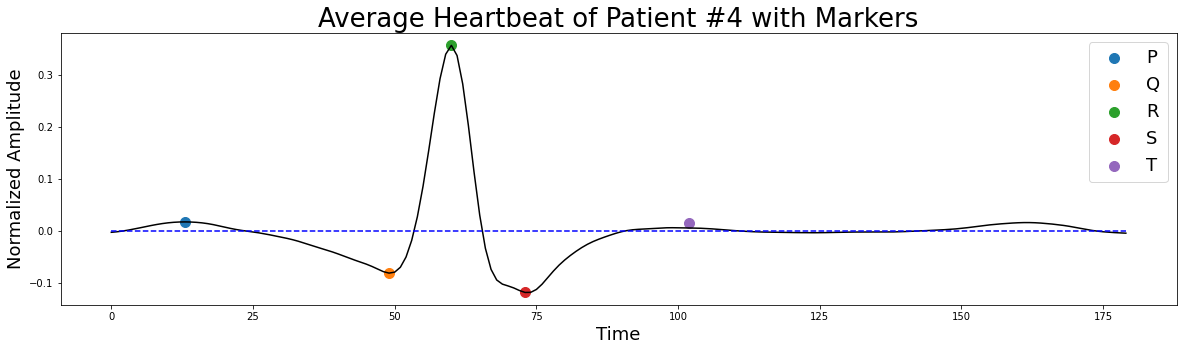

In [22]:
#On the example above add some markers to show where each Peak and Trough is located
#Example Visualization
print("The Q peak value for patient 5 is ", PQRST_Average_perPatient_train[3,1]) #this is the P peak for patient 4
print("It is found in index/time ", PQRST_Average_perPatient_train[3, 6]) #This is the P peakindex for patient 4
P =  PQRST_Average_perPatient_train[3][0] ; Pindex =  PQRST_Average_perPatient_train[3][5]
Q =  PQRST_Average_perPatient_train[3][1] ; Qindex =  PQRST_Average_perPatient_train[3][6]
R =  PQRST_Average_perPatient_train[3][2] ; Rindex =  PQRST_Average_perPatient_train[3][7]
S =  PQRST_Average_perPatient_train[3][3] ; Sindex =  PQRST_Average_perPatient_train[3][8] 
T =  PQRST_Average_perPatient_train[3][4] ; Tindex =  PQRST_Average_perPatient_train[3][9]
plt.plot(average_heartbeats_train[3] , '-k')  #plot the heartbeat for patient 4
plt.ylabel("Normalized Amplitude",fontsize=18)
plt.xlabel("Time",fontsize= 18)
plt.title("Average Heartbeat of Patient #4 with Markers" , fontsize=26)
plt.plot(np.arange(0, 180),np.zeros(180), '--b')
plt.scatter(Pindex, P , label= "P" , marker = "o", s=100)
plt.scatter(Qindex, Q , label= "Q" , marker = "o",s=100)
plt.scatter(Rindex, R , label= "R" , marker = "o" , s=100)
plt.scatter(Sindex, S , label= "S" , marker = "o" ,s=100)
plt.scatter(Tindex, T , label= "T" , marker = "o" , s=100)
plt.legend(prop={'size': 18})
plt.show()

###  Method 2: Indentify all Rpeaks in the templates, extract them and find average/median per patient

In [23]:
#Extract all indeces of P peaks
def get_Rpeaks(raw , indeces):
    R_peaks = []
    for i in range(0,raw.shape[0]):
        R_peak  = raw[indeces[i][0]]
        R_peaks.append(R_peak)
    print(np.array(R_peaks).shape)   
    return np.array(R_peaks)

    
#Extract all indeces of Q peaks
#EXtract all indeces of R peaks
#Extract all indeces of S peaks
#Extract all indeces of T peaks

### Mean, Median difference of Rpeaks (Amplitude & Interval)

In [24]:
def get_R_statistics(templates , r_peaks , r_peaks_indeces):
    template_differences = np.zeros((templates.shape[0] , 12))
    for i in range(0,templates.shape[0]):
        d =np.diff(templates[i]) #gives the difference between consecutive sequences template[i+1] and tempalte[i]
        d_R = np.diff(r_peaks) #gives difference between next element in the array 
        d_Rintervals = np.diff(r_peaks_indeces[0])
        mean_diff = [np.mean(d) , np.mean(d_R) , np.mean(d_Rintervals)]
        std_diff = [np.std(d) , np.std(d_R) , np.std(d_Rintervals)]
        median_diff  = [np.median(d) , np.median(d_R) , np.median(d_Rintervals)]
        variance_diff = [np.var(d) , np.var(d_R) , np.var(d_Rintervals)]
        
    template_differences[i][0] = mean_diff[0]
    template_differences[i][1] = std_diff[0]
    template_differences[i][2] = median_diff[0]
    template_differences[i][3] = variance_diff[0]
    template_differences[i][4] = mean_diff[1]
    template_differences[i][5] = std_diff[1]
    template_differences[i][6] = median_diff[1]
    template_differences[i][7] = variance_diff[1]
    template_differences[i][8] = mean_diff[2]
    template_differences[i][8] = std_diff[2]
    template_differences[i][10] = median_diff[2]
    template_differences[i][11] = variance_diff[2]

    return template_differences




### QRS and QT time intervals

In [25]:
#QRS and QT (etc.) intervals for both an average and median profile
def get_time_intervals(PQRST_Average_perPatient , PQRST_Median_perPatient):
    QR_index_Average = PQRST_Average_perPatient[:,7]- PQRST_Average_perPatient[:,7]
    RS_index_Average = PQRST_Average_perPatient[:,8]- PQRST_Average_perPatient[:,7]
    PT_index_Average = PQRST_Average_perPatient[:,9]- PQRST_Average_perPatient[:,5]
    QT_index_Average = PQRST_Average_perPatient[:,9]- PQRST_Average_perPatient[:,6]
    QRS_index_Average = PQRST_Average_perPatient[:,8]- PQRST_Average_perPatient[:,6]
    PQ_index_Average = PQRST_Average_perPatient[:,5]- PQRST_Average_perPatient[:,6]
    ST_index_Average = PQRST_Average_perPatient[:,8]- PQRST_Average_perPatient[:,9]
    PS_index_Average = PQRST_Average_perPatient[:,5]- PQRST_Average_perPatient[:,8]
    QRS_T_ratio_index_Average = np.divide(QRS_index_Average ,PQRST_Average_perPatient[:,9])
    QRS_P_ratio_index_Average = np.divide(QRS_index_Average, PQRST_Average_perPatient[:,5])
    QRS_ST_rato_index_Average = np.divide(QRS_index_Average ,ST_index_Average)

    QR_index_Median = PQRST_Median_perPatient[:,7]- PQRST_Median_perPatient[:,7]
    RS_index_Median = PQRST_Median_perPatient[:,8]- PQRST_Median_perPatient[:,7]
    PT_index_Median = PQRST_Median_perPatient[:,9]- PQRST_Median_perPatient[:,5]
    QT_index_Median = PQRST_Median_perPatient[:,9]- PQRST_Median_perPatient[:,6]
    QRS_index_Median = PQRST_Median_perPatient[:,8]- PQRST_Median_perPatient[:,6]
    PQ_index_Median =  PQRST_Median_perPatient[:,5]- PQRST_Median_perPatient[:,6]
    ST_index_Median =  PQRST_Median_perPatient[:,8]- PQRST_Median_perPatient[:,9]
    PS_index_Median =  PQRST_Median_perPatient[:,5]- PQRST_Median_perPatient[:,8]
    QRS_T_ratio_index_Median = np.divide(QRS_index_Median ,PQRST_Median_perPatient[:,9])
    QRS_P_ratio_index_Median = np.divide(QRS_index_Median ,PQRST_Median_perPatient[:,5])
    QRS_ST_rato_index_Medin = np.divide(QRS_index_Median ,ST_index_Median)
    
    time_intervals = [QR_index_Average , RS_index_Average ,PT_index_Average , QT_index_Average,
                      QRS_index_Average, PQ_index_Average, ST_index_Average, PS_index_Average, 
                      QRS_T_ratio_index_Average, QRS_P_ratio_index_Average, QRS_ST_rato_index_Average,
                      RS_index_Median , PT_index_Median, QT_index_Median , QRS_index_Median, 
                      PQ_index_Median, ST_index_Median, PS_index_Median , QRS_T_ratio_index_Median,
                      QRS_P_ratio_index_Median,QRS_ST_rato_index_Medin ] ;

    return np.transpose(np.array(time_intervals))

### QRS and QT values difference

In [26]:
#QRS and QT (etc.) peaks difference  for both an average and median profile
def get_values_difference(PQRST_Average_perPatient , PQRST_Median_perPatient):
    PQ_Average = PQRST_Average_perPatient[:,0]- PQRST_Average_perPatient[:,1]
    QR_Average = PQRST_Average_perPatient[:,1]- PQRST_Average_perPatient[:,2]
    RS_Average = PQRST_Average_perPatient[:,2]- PQRST_Average_perPatient[:,3]
    PT_Average = PQRST_Average_perPatient[:,0]- PQRST_Average_perPatient[:,4]
    QT_Average = PQRST_Average_perPatient[:,1]- PQRST_Average_perPatient[:,4]
    QRS_Average = PQRST_Average_perPatient[:,1]- PQRST_Average_perPatient[:,3]
    ST_Average = PQRST_Average_perPatient[:,3]- PQRST_Average_perPatient[:,4]
    PS_Average = PQRST_Average_perPatient[:,0]- PQRST_Average_perPatient[:,3]
    QRS_T_ratioAverage = np.divide(QRS_Average , PQRST_Average_perPatient[:,4])
    QRS_P_ratioAverage = np.divide(QRS_Average, PQRST_Average_perPatient[:,0])

    PQ_Median = PQRST_Median_perPatient[:,0]- PQRST_Median_perPatient[:,1]
    QR_Median = PQRST_Median_perPatient[:,1]- PQRST_Median_perPatient[:,2]
    RS_Median = PQRST_Median_perPatient[:,2]- PQRST_Median_perPatient[:,3]
    PT_Median = PQRST_Median_perPatient[:,0]- PQRST_Median_perPatient[:,4]
    QT_Median = PQRST_Median_perPatient[:,1]- PQRST_Median_perPatient[:,4]
    QRS_Median= PQRST_Median_perPatient[:,1]-PQRST_Median_perPatient[:,3]
    ST_Median = PQRST_Median_perPatient[:,3]- PQRST_Median_perPatient[:,4]
    PS_Median = PQRST_Median_perPatient[:,0]- PQRST_Median_perPatient[:,3]
    QRS_T_ratioMedian = np.divide(QRS_Median,PQRST_Median_perPatient[:,4])
    QRS_P_ratioMedian = np.divide(QRS_Median,PQRST_Median_perPatient[:,0])

    values = [PQ_Average , QR_Average ,RS_Average ,PT_Average ,QT_Average ,QRS_Average, ST_Average, PS_Average, 
              QRS_T_ratioAverage, QRS_P_ratioAverage,
              PQ_Median , QR_Median ,RS_Median , PT_Median ,QT_Median ,QRS_Median, ST_Median, PS_Median ,
              QRS_T_ratioMedian, QRS_P_ratioMedian]
    
    return np.transpose(np.array(values))

### Heart rates max,min,mode,mean,median, variance,std

In [27]:
def get_heart_rates_stats(heart_rate , heart_rate_ts):
    #Because the heartrates are diffferent in shape for each person, we should use mean
    patients = heart_rate.shape[0]
    heart_rate_basics = np.zeros((patients,18)) #11 for the number of features we add in the array

    for i in range(0,patients): #check if the array is empty
        if(heart_rate[i].size == 0 ):
            print(i,"No")
            heart_rate[i] = [0.0 ,0.0 ,0.0 , 0.0 ,0.0]
        else:
            #print(heart_rate[i])
            mean_heart_rate = np.mean(heart_rate[i] , axis= 0)
            median_heart_rate = np.median(heart_rate[i])
            variance_heart_rate = np.var(heart_rate[i])
            std_heart_rate = np.std(heart_rate[i])
            max_heart_rate = np.max(heart_rate[i] , axis= 0)
            min_heart_rate = np.min(heart_rate[i] , axis= 0)
            mode_heart_rate = stats.mode(heart_rate[i] , axis= 0)[0][0] #it returns 2 arrays and the mode is in the first on.
            #We also want to get the first element of the mode array.
            diff_max_mean_rate = max_heart_rate - mean_heart_rate
            diff_max_median_rate = max_heart_rate - median_heart_rate
            diff_min_mean_rate = min_heart_rate - mean_heart_rate
            diff_min_median_rate = min_heart_rate - median_heart_rate
            diff_median_mode = median_heart_rate - mode_heart_rate
            diff_median_mean = median_heart_rate -  mean_heart_rate
            diff_mode_mean = mode_heart_rate - mean_heart_rate
            #get the difference between the previous and next sequence for heart rates (time wise)
            d = np.diff(heart_rate_ts[i])
            mean_diff_ts = np.mean(d)
            std_diff_ts = np.std(d)
            variance_diff_ts = np.mean(d)-np.var(d)
            median_diff_ts = np.median(d)
            
            
            
            heart_stats = [mean_heart_rate, median_heart_rate, variance_heart_rate ,std_heart_rate ,max_heart_rate,
                           min_heart_rate, mode_heart_rate, diff_max_mean_rate, diff_max_median_rate, diff_min_mean_rate,
                           diff_min_median_rate, diff_median_mode, diff_median_mean, diff_mode_mean, mean_diff_ts, std_diff_ts,
                           variance_diff_ts, median_diff_ts]
            
            heart_rate_basics[i] = heart_stats

            '''heart_rate_basics[i][0]= mean_heart_rate
            heart_rate_basics[i][1]= median_heart_rate
            heart_rate_basics[i][2]= variance_heart_rate
            heart_rate_basics[i][3]= std_heart_rate
            heart_rate_basics[i][4]= max_heart_rate
            heart_rate_basics[i][5]= min_heart_rate
            heart_rate_basics[i][6]= mode_heart_rate
            heart_rate_basics[i][7]= diff_max_mean_rate
            heart_rate_basics[i][8]= diff_max_median_rate
            heart_rate_basics[i][9]= diff_min_mean_rate
            heart_rate_basics[i][10]= diff_min_median_rate
            heart_rate_basics[i][11]= diff_median_mode
            heart_rate_basics[i][12]= diff_median_mean
            heart_rate_basics[i][13]= diff_mode_mean
            heart_rate_basics[i][14]= mean_diff_ts
            heart_rate_basics[i][15]= std_diff_ts
            heart_rate_basics[i][16]= variance_diff_ts
            heart_rate_basics[i][17]= median_diff_ts '''
            
            
    #print("An example for patient 0 , is " , heart_rate_basics[0].shape)
    return heart_rate_basics

### Energy of Signal & DWT

In [28]:
import pywt
def energy_of_signal(heartbeats_of_all_patients):
    energies = []
    #db2 coefficients
    cA_list=[]
    cD_list=[]
    num_coeffs_list = []
    patients = heartbeats_of_all_patients.shape[0]
    for i in range(0,patients):
        squared = np.power(heartbeats_of_all_patients[i],2)
        energy = np.sum(squared)
        energies.append(energy)
        cA, cD = pywt.dwt(heartbeats_of_all_patients[i], 'db2', mode='periodic')
        CA = np.sum(np.sum(cA,axis=1))
        CD = np.sum(np.sum(cD,axis=1))
        numCoeffs = np.array(cA).shape[0]
        #print(numCoeffs)
        #print(CA)
        #print(CD)
        cA_list.append(CA)
        cD_list.append(CD)
        num_coeffs_list.append(numCoeffs)
    

    energies = np.transpose(np.array([energies, cA_list , cD_list , num_coeffs_list]))
    print("Shape is" , energies.shape)
    return np.array(energies)

Energy_train = energy_of_signal(templates_train)

    

Shape is (5117, 4)


## Gather all features

In [29]:
#All training features
heart_rates_statistics_train = get_heart_rates_stats(heart_rate_train , heart_rate_ts_train)
timeIntervals_train = get_time_intervals(PQRST_Average_perPatient_train , PQRST_Median_perPatient_train)
valuesDifference_train =get_values_difference(PQRST_Average_perPatient_train , PQRST_Median_perPatient_train)
Energy_train = energy_of_signal(templates_train)
R_stats_train = get_R_statistics(ts_train , get_Rpeaks(x_raw_train , rpeaks_train) , rpeaks_train )

'''heart_rates_statistics_train = np.nan_to_num(heart_rates_statistics_train)
timeIntervals_train = np.nan_to_num(timeIntervals_train)
valuesDifference_train = np.nan_to_num(valuesDifference_train)
R_stats_train  = np.nan_to_num(R_stats_train)
Energy_train = np.nan_to_num(Energy_train) '''

all_train_features = np.concatenate((train_signal_related_features, Energy_train,
                                     heart_rates_statistics_train , timeIntervals_train, 
                                     valuesDifference_train , PQRST_Average_perPatient_train , 
                                     PQRST_Median_perPatient_train , R_stats_train), axis= 1)  # without train_frequency_domain_statistics for most models
print("The final training features shape is ",all_train_features.shape)

317 No


D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of 

2693 No
3107 No
4058 No
4654 No


D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


Shape is (5117, 4)
(5117, 8500)
The final training features shape is  (5117, 99)


In [30]:
'''heart_rates_statistics_train = np.nan_to_num(heart_rates_statistics_train)
timeIntervals_train = np.nan_to_num(timeIntervals_train)
valuesDifference_train = np.nan_to_num(valuesDifference_train)
R_stats_train  = np.nan_to_num(R_stats_train)
Energy_train = np.nan_to_num(Energy_train) '''
Energy_train = energy_of_signal(templates_train)



all_train_features = np.concatenate((train_signal_related_features, Energy_train,
                                     heart_rates_statistics_train , timeIntervals_train, 
                                     valuesDifference_train , PQRST_Average_perPatient_train , 
                                     PQRST_Median_perPatient_train , R_stats_train), axis= 1)  # without train_frequency_domain_statistics for most models
print("The final training features shape is ",all_train_features.shape)

Shape is (5117, 4)
The final training features shape is  (5117, 99)


In [31]:
#All testing features
heart_rates_statistics_test = get_heart_rates_stats(heart_rate_test ,heartrate_ts_test)
timeIntervals_test = get_time_intervals(PQRST_Average_perPatient_test , PQRST_Median_perPatient_test)
valuesDifference_test =get_values_difference(PQRST_Average_perPatient_test , PQRST_Median_perPatient_test)
R_stats_test = get_R_statistics(ts_test, get_Rpeaks (x_raw_test , rpeaks_test) , rpeaks_test)
Energy_test = energy_of_signal(templates_test)

604 No
1587 No
2723 No


D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


(3411, 8500)
Shape is (3411, 4)


In [32]:
Energy_test = energy_of_signal(templates_test)

'''heart_rates_statistics_test = np.nan_to_num(heart_rates_statistics_test)
timeIntervals_test = np.nan_to_num(timeIntervals_test)
valuesDifference_test = np.nan_to_num(valuesDifference_test)
R_stats_test  = np.nan_to_num(R_stats_test , get_Rpeaks (x_raw_train , rpeaks_test) , rpeaks_test)
Energy_test = np.nan_to_num(Energy_test) '''
all_test_features = np.concatenate((test_signal_related_features, Energy_test ,
                                    heart_rates_statistics_test , timeIntervals_test,  # without test_frequency_domain_statistics
                                    valuesDifference_test , PQRST_Average_perPatient_test , 
                                    PQRST_Median_perPatient_test, R_stats_test), axis= 1)
print("The final testing features shape is ",all_test_features.shape)

Shape is (3411, 4)
The final testing features shape is  (3411, 99)


In [67]:
#Replace any NaN with 0 value
all_train_features = np.nan_to_num(all_train_features ,  0.0)
all_test_features = np.nan_to_num(all_test_features,  0.0)

In [384]:
from sklearn.feature_selection import SelectKBest,f_classif , chi2

Kbest = SelectKBest(f_classif , k=70).fit(all_train_features, y_train_no_id)
K_train_features = Kbest.transform(all_train_features)
K_test_features = Kbest.transform(all_test_features)

D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\sklearn\utils\__init__.py:712: RuntimeWarning: overflow encountered in square
  X = X ** 2
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Conda Installation\envs\gpu_python3.6\lib\site-packages\sklearn\uti

### Class Weights

In [278]:
#Define class weights based on the different number of samples
n_0 = class0_labels.shape[0]
n_1 = class1_labels.shape[0]
n_2 = class2_labels.shape[0]
n_3 = class3_labels.shape[0]
n_total = n_0+n_1+n_2+n_3
weight0 = max(n_0,n_1,n_2,n_3)/n_0
weight1 = max(n_0,n_1,n_2,n_3)/n_1
weight2 = max(n_0,n_1,n_2,n_3)/n_2
weight3 = max(n_0,n_1,n_2,n_3)/n_3
weights = {0:weight0, 1:weight1, 2:weight2 , 3:weight3}
print(weight0 ,weight1,weight2 , weight3)

1.0 6.839729119638826 2.055630936227951 17.823529411764707


# XGB

In [119]:
import xgboost

XGB = xgboost.XGBClassifier(colsample_bytree=0.4,
                     gamma=0,                 
                     learning_rate=0.01,
                     max_depth=3,
                     min_child_weight=1.5,
                     n_estimators=4000,                                                                    
                     reg_alpha=0.75,
                     reg_lambda=0.45,
                     subsample=0.6,
                     seed=42)


# Logistic Regression

In [361]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
#SGD = SGDClassifier(class_weight = weights).fit(X_new_train , y_train_no_id)
LR = LogisticRegression(solver='newton-cg', 
                        multi_class='multinomial',
                        C=0.02,          # inverse of regularisation strength (smaller -> stronger)
                        class_weight='balanced')


## Model Selection - CV

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def eval_splits(model , cv , data , labels):
    models_scores = []
    for i in range(0,cv):
        X_train, X_val, y_train, y_val = train_test_split(data, labels , test_size=0.2, random_state=2*i)
        model.fit(X_train , y_train)
        y_pred = model.predict(X_val)
        F1 = f1_score(y_val, y_pred, average='micro')
        models_scores.append(F1)
        print(F1)
    print("Mean is" , np.mean(np.array(models_scores)))

In [120]:
eval_splits(LightGBM, 10 , adaboost_train ,y_train_no_id)

[LightGBM] [Warning] Unknown parameter: gamma
0.8125
[LightGBM] [Warning] Unknown parameter: gamma
0.8046875
[LightGBM] [Warning] Unknown parameter: gamma
0.7978515625
[LightGBM] [Warning] Unknown parameter: gamma
0.818359375
[LightGBM] [Warning] Unknown parameter: gamma
0.822265625
[LightGBM] [Warning] Unknown parameter: gamma
0.791015625
[LightGBM] [Warning] Unknown parameter: gamma
0.794921875
[LightGBM] [Warning] Unknown parameter: gamma
0.8115234375
[LightGBM] [Warning] Unknown parameter: gamma
0.8115234375
[LightGBM] [Warning] Unknown parameter: gamma
0.80078125
Mean is 0.80654296875


# Neural Network

In [65]:
import random 
random.seed(0)
#NEural Network
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import Activation , Flatten, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf



# define model
train_X, val_X, train_y, val_y = train_test_split(adaboost_train, y_train_no_id, test_size=0.2, random_state=42)
train_X = np.expand_dims(train_X , axis=2)
val_X = np.expand_dims(val_X , axis=2)
input_shape = train_X.shape
print("The input shape is ",input_shape)
# it will correspond to the sample size
filters = 500
def NeuralNetwork():
    model = Sequential()
    # define first hidden layer and visible layer
    model.add(Dense(filters, input_shape= input_shape, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Convolution1D(filters, 3, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    
    
    # define loss and optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model


The input shape is  (4093, 93, 1)


In [66]:
model = NeuralNetwork()
model.fit(train_X, train_y, epochs=100, batch_size = 5 ,verbose=0 , validation_data=(val_X, val_y))
test_X = np.expand_dims(adaboost_test , axis=2)
y_pred = model.predict(test_X, batch_size = 5) #inference 
#NN = KerasClassifier(build_fn=NeuralNetwork , epochs=100, batch_size=100, verbose=0)  
#NN._estimator_type = "classifier" #to make it an estimator 
#print(cross_val_score(NN, X_new_train,y_train_no_id, cv=3))
y_predNN = np.argmax(y_pred,axis=1)

ValueError: Input 0 is incompatible with layer conv1d_4: expected ndim=3, found ndim=4

# CatBoost Classifier

# LightGBM

In [100]:
import lightgbm as ltb
LightGBM = ltb.LGBMClassifier(colsample_bytree=0.9,   
                            objective='multi:softmax',
                            gamma=1,  
                            num_leaves=62,
                            learning_rate=0.05,
                            max_depth=10,       
                            min_child_weight=1,   
                            n_estimators=2000,                                                     
                            reg_alpha=3,       
                            reg_lambda=0.5,       
                            subsample=0.9,         
                            seed=42 )

# AdaBoost

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
adaboost_train = np.delete(all_train_features , (35,36,45,46,56,66) , 1) # remore all indeces that have NaN features
adaboost_test = np.delete(all_test_features, (35,36,45,46,56,66) , 1) #remove all indeces that have NaN features
number_of_features = adaboost_train.shape[1]
AdaBoost = GradientBoostingClassifier(learning_rate=0.05, n_estimators=2000, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=number_of_features , random_state=12)

# Training and Predictions

In [105]:
#RF.fit(all_train_features , y_train_no_id)
#y_predRF = RF.predict(all_test_features)

#LR.fit(all_train_features , y_train_no_id)
#y_predLR = LR.predict(all_test_features)

LightGBM.fit(adaboost_train , y_train_no_id)
y_predLGBM = LightGBM.predict(adaboost_test)
print("LightGBM predictions are ready")

'''
XGB.fit(adaboost_train , y_train_no_id)
y_predXGB = XGB.predict(adaboost_test)
print("XGBoost predictions are ready")

#SVC.fit(all_train_features , y_train_no_id)
#y_predSVC = SVC.predict(all_test_features)
AdaBoost.fit(adaboost_train , y_train_no_id)
y_predBoost = AdaBoost.predict(adaboost_test)
print("AdaBoost predictions are ready")   '''

[LightGBM] [Warning] Unknown parameter: gamma
LightGBM predictions are ready


'\nXGB.fit(adaboost_train , y_train_no_id)\ny_predXGB = XGB.predict(adaboost_test)\nprint("XGBoost predictions are ready")\n\n#SVC.fit(all_train_features , y_train_no_id)\n#y_predSVC = SVC.predict(all_test_features)\nAdaBoost.fit(adaboost_train , y_train_no_id)\ny_predBoost = AdaBoost.predict(adaboost_test)\nprint("AdaBoost predictions are ready")   '

# Voting Classifier

In [454]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[ ('AdaBoost', AdaBoost) , ('XGB', XGB)], voting='soft', n_jobs=4)
votingC = votingC.fit(adaboost_train, y_train_no_id)
y_predVC = votingC.predict(adaboost_test)

# Extraction of y-prediction values to a csv called "sample_final.csv"

In [40]:

def extract_csv(y_pred):
    id_list = x_test.loc[: , 'id']
    print("The prediction shape is" ,y_pred.shape)
    print("The id list shape is" ,id_list.shape)

    #y_pred = np.round(y_pred) #uncomment only if you use a regressor

    # Alternative ways to create a pd ---> Panda DataFrame
    #sample_pd = pd.DataFrame( data , columns = ["id", "y"])
    sample_pd = pd.DataFrame({'id': id_list, 'y': y_pred})
    sample_pd.to_csv(r'sample_final.csv', index = False)  #output dataframe to a csv file
    print("The csv file has been created successfully")

In [118]:
# Extract
s = np.squeeze(y_predCAT ,axis=1)
np.savetxt("LGBM.csv", (y_predLGBM))
#final_pred= VC.predict(all_test_features)
extract_csv(y_predXGB)

The prediction shape is (3411,)
The id list shape is (3411,)


AttributeError: 'DataFrame' object has no attribute '_mgr'

### Best Model
1.Undersampling

2.SVC(C=2) and weights

### 2nd Best Model
1.Min-Max Scaling

2.Kbest (532)

3.Weighted Logistic Regression

4.(or even NN)